In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

AiiDA tutorialから題材を得る。

1. 元素を与えてdefaultの格子を得る
1. 格子定数を定数倍した格子（複数）を得る
1. それらの格子の体積を平均する。

を行う。

まず、「格子定数を定数倍した格子（単数）を得る」の部分を行う。

# AiiDAの内部で用いる関数の定義

SiもしくはGeの格子を得る。

@calcfunctionなので、入出力はAiiDAの型でなければならない。
- elementはStr型である。

In [2]:
from aiida.engine import calcfunction,workfunction
import numpy as np
from aiida.orm import Str,Float
from aiida.plugins import DataFactory

POSCAR.SiもしくはPOSCAR.Geから構造を読み込む

In [3]:
@calcfunction
def load_poscar(element):
    symbol = element.value
    from pymatgen.core.structure import Structure
    filename = "POSCAR."+symbol
    struc = Structure.from_file(filename)
    StructureData = DataFactory("core.structure")
    structure = StructureData()
    structure.set_pymatgen(struc)
    return structure

structure = load_poscar(Str("Si"))
structure

<StructureData: uuid: 2d674574-fe13-449f-b5df-29937c52080b (pk: 9441)>

入力格子を定数倍した格子を返す

In [4]:
@calcfunction
def rescale(structure, scale):
    """
    Workfunction to rescale a structure

    :param structure: An AiiDA structure to rescale
    :param scale: The scale factor (for the lattice constant)
    :return: The rescaled structure
    """
    the_ase = structure.get_ase()
    new_ase = the_ase.copy()
    new_ase.set_cell(the_ase.get_cell() * float(scale), scale_atoms=True)
    new_structure = DataFactory('core.structure')(ase=new_ase)
    return new_structure

## @workfunctionの定義



In [5]:
@workfunction
def create_rescaled(element, scale):
    """
    Workfunction to create and immediately rescale
    a crystal structure of a given element.
    """
    s0 = load_poscar(element)
    return rescale(s0,scale)

実行

In [6]:
from aiida.orm import Str,Float
s1 = create_rescaled(element= Str("Si"), scale=Float(0.98))
s1

<StructureData: uuid: abf2932f-d00c-4c05-9af3-0f1af0b3141c (pk: 9448)>

Success: Output written to `9448.dot.pdf`


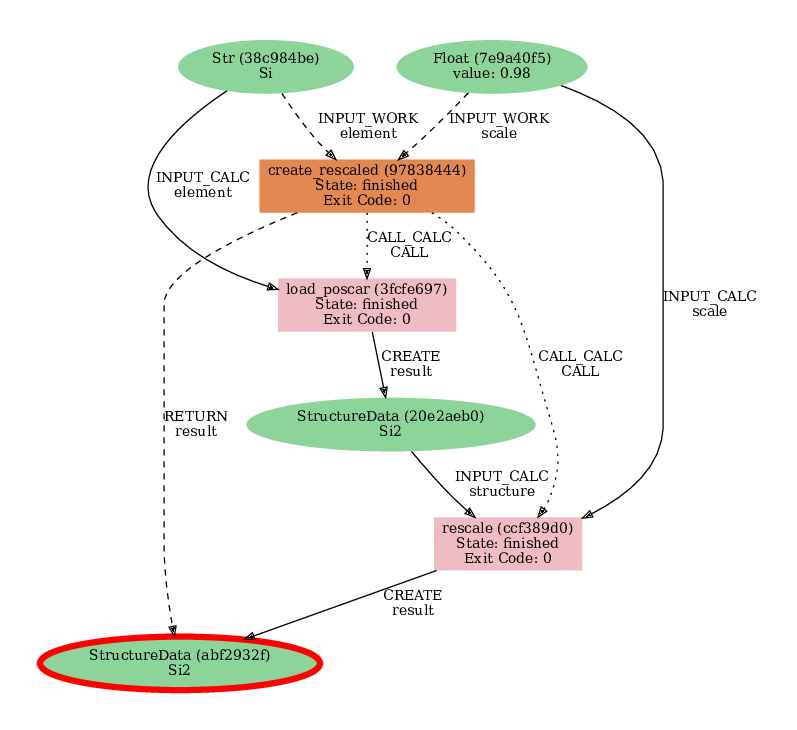

In [7]:
import subprocess
cmd = "verdi node graph generate {}".format(s1.pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(s1.pk))

# runを用いた実行

@workfunctionはrunを用いて実行可能。

In [8]:
from aiida.engine import submit, run
inputs = {"element": Str("Si"), "scale":Float(0.98)}
result = run.get_node(create_rescaled, **inputs)
result

<StructureData: uuid: 4abc6045-a6d5-4170-b5e1-75fb1c7bb3b1 (pk: 9455)>

Success: Output written to `9455.dot.pdf`


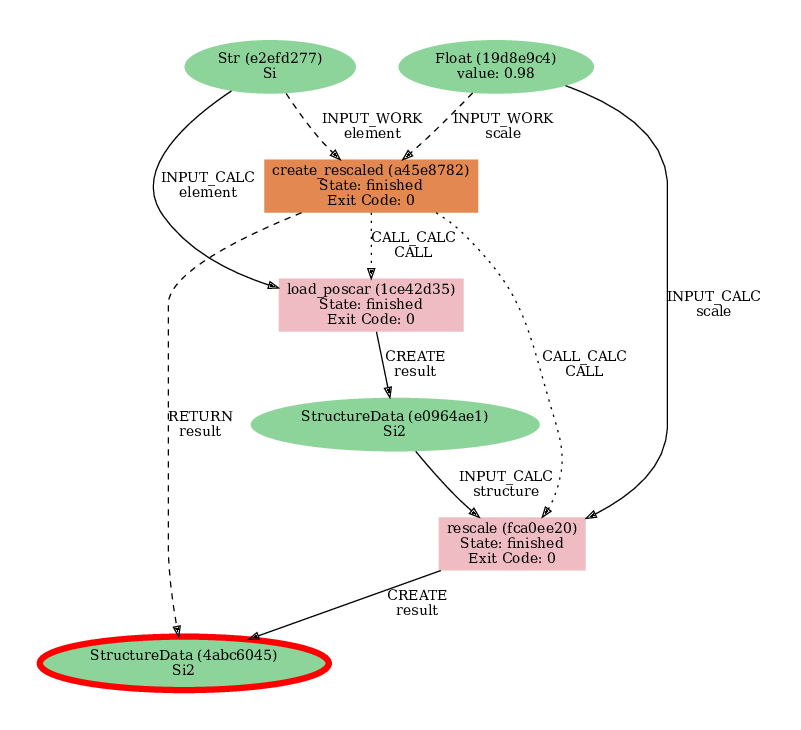

In [9]:
import subprocess
cmd = "verdi node graph generate {}".format(result.pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(result.pk))

まだ、外部ファイル化していないのでsubmitを用いた実行はできない。
次は実行するとエラーが起きる。

In [10]:
from aiida.engine import submit, run
inputs = {"element": Str("Si"), "scale":Float(0.98)}
result = submit(create_rescaled, **inputs)
# It will fails.

以下では外部ファイル化を行う。